Import all the required packages

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

#Beam length: L, Force magnitude and location: P, Young's modulus and Second moment of Ares: E,I, Deflection at the end: y
Let us take different combinations of L,P,E,I and call it feature vectors X=[L P E I]
and deflection $y=[PL^{3}3/E/I]$

In [17]:
nnl=100
nnp=100
nne=100
nni=100
#L=np.linspace(start=0.5,stop=4,num=10000)
#P=np.linspace(start=34.3e3,stop=34.3e3,num=1)
#E=np.linspace(start=21e9,stop=21e9,num=1)
#I=np.linspace(start=33.3e-8,stop=33.3e-8,num=1)
L=np.random.uniform(low=0.0,high=10.0,size=nnl)
P=np.random.uniform(low=0.0,high=100e3,size=nnp)
E=np.random.uniform(low=0.1e9,high=1000e9,size=nne)
I=np.random.uniform(low=0.0,high=1e-7,size=nni)

In [18]:
def max_deflection(l,p,e,i):
    return p*l*l*l/3/e/i

In [19]:
X=np.zeros((len(L)*len(P)*len(E)*len(I),4))
y=np.zeros((len(L)*len(P)*len(E)*len(I),1))
counter=0
for i in range(len(L)):
    for j in range(len(P)):
        for k in range(len(E)):
            for l in range(len(I)):
                X[counter,0]=L[i]
                X[counter,1]=P[j]
                X[counter,2]=E[k]
                X[counter,3]=I[l]
                y[counter,0]=max_deflection(L[i],P[j],E[k],I[l])
                counter = counter +1

Split the (X,y) data into training, testing and valication seubsets

In [20]:
def split_test_train_val(X,y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.2,random_state = 0)
    X_test, X_val,y_test,y_val =  train_test_split(X_test,y_test,test_size=0.2,random_state = 0)
    return X_train,X_test,X_val,y_train,y_test,y_val

In [21]:
output = open('data.pkl', 'wb')
pickle.dump([X,y],output)

Do feature scaling to ensure better convergence during the optimization process.

In [22]:
from sklearn.preprocessing import scale
X=scale(X)

/home/adil/.anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Just peek into the data to see how deflection y varies with L

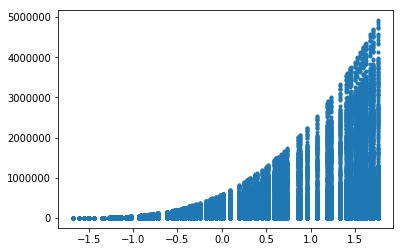

In [23]:
plt.plot(X[:,0],y[:],'.')
plt.show()

In [24]:
X_train,X_test,X_val,y_train,y_test,y_val=split_test_train_val(X,y)

In [25]:
def predict(clf, input_features):
    prediction=clf.predict(input_features)
    return prediction

def print_error(train,test,target_train,target_test,parameter):
    print("Mean squared error on training set using ",parameter,np.mean((train-target_train)**2))
    print("Mean squared error on test set using  ",parameter,np.mean((test-target_test)**2))

Functions for Linear Regression, Random Forest and Deep Neural Network

In [33]:
def LR(X_train,X_test,y_train,y_test):
    from sklearn import linear_model
    clf = linear_model.LinearRegression()
    clf.fit(X_train, y_train)
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'LR')
    return clf

def RF(X_train,X_test,y_train,y_test,max_depth):
    from sklearn.ensemble import RandomForestRegressor
    clf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    clf.fit(X_train, y_train)    
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'RF')
    return clf
def ANN(X_train,X_test,y_train,y_test):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.utils import np_utils
    m,input_layer_size=X_test.shape
    hidden_layer_size = input_layer_size   
    clf = Sequential()
    clf.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_layer_size))
    clf.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))
    clf.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu'))
    clf.add(Dense(units = 1, kernel_initializer = 'normal'))
    clf.compile(loss='mean_squared_error', optimizer='adam')
    print("Shapes of y_test, y_prediction ",predict(clf,X_test).shape,y_test.shape)
    history=clf.fit(X_train, y_train, batch_size = 1000000, epochs = 1000,verbose=0)
    print_error(predict(clf,X_train),predict(clf,X_test),y_train,y_test,'ANN')
    return clf

In [28]:
def plot_comparision(prediction,target,output):
    from sklearn import linear_model
    plt.plot(target,prediction,'.')
    plt.plot([0,np.max(target)],[0,np.max(target)],color='k', linestyle='-')
    plt.xlabel("Observation")
    plt.ylabel("Prediction")
    plt.savefig(output,bbox_inches='tight')
    plt.show()

Linear Regression because of its inability to detect features performs badly. 

Mean squared error on training set using  LR 281359713.642
Mean squared error on test set using   LR 286070380.367


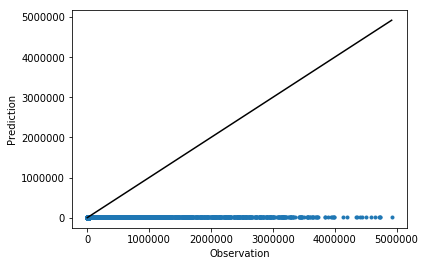

In [29]:
clf_LR=LR(X_train,X_test,y_train,y_test);
plot_comparision(predict(clf_LR,X_test),y_test,'test.pdf')

Mean squared error on training set using  RF 9023.26507215
Mean squared error on test set using   RF 29481.9966077


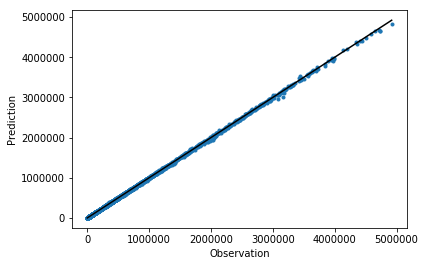

In [30]:
clf_RF=RF(X_train,X_test,y_train.ravel(),y_test.ravel(),20);
plot_comparision(predict(clf_RF,X_test),y_test,'test2.pdf')

Shapes of y_test, y_prediction  (16000000, 1) (16000000, 1)
Mean squared error on training set using  ANN 3847134.48537
Mean squared error on test set using   ANN 3840523.30998


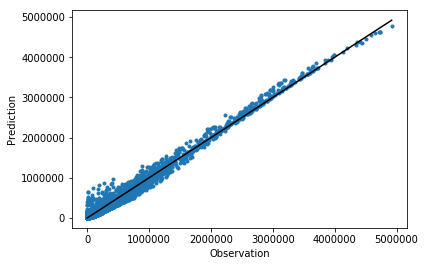

In [34]:
clf_ANN=ANN(X_train,X_test,y_train,y_test)
plot_comparision(predict(clf_ANN,X_test),y_test,'test.pdf')

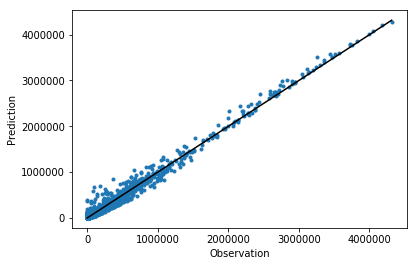

In [35]:
plot_comparision(predict(clf_ANN,X_val),y_val,'test.pdf')